In [1]:
import os
import sys, os, argparse, gc, time, numpy as np, tensorflow as tf, pandas as pd
from leo_segmentation.utils import load_config, check_experiment, get_named_dict, \
                        log_data, load_yaml, train_logger, val_logger, print_to_string_io, \
                        save_pickled_data, model_dir, list_to_tensor, numpy_to_tensor, prepare_inputs,\
                        tensor_to_numpy
from leo_segmentation.data import PascalDatagenerator, GeneralDatagenerator
from run import train_model, evaluate_model
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#os.chdir("./leo_segmentation")

## Train Model

In [3]:
config = load_config()
dataset = "pascal_5i"
fold = 1

In [4]:
#leo = train_model(config, dataset, fold)

## Evaluation

In [5]:
mode = "meta_val"
dataloader = PascalDatagenerator(dataset, data_type=mode)
img_transformer = dataloader.transform_image
mask_transformer = dataloader.transform_mask
transformers = (img_transformer, mask_transformer)
val_meta_data = dataloader.get_batch_data()
class_in_metadata = val_meta_data[4]
print(f"classes in mode {mode}: {class_in_metadata}")

classes in mode meta_val: ['bicycle', 'bird', 'aeroplane', 'bottle', 'boat']


In [23]:
def unnormalize_img(img):
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    img = img * std + mean
    return img

In [24]:
select_class = 1
print("class", class_in_metadata[select_class], "is selected")
batch_data = get_named_dict(val_meta_data, select_class)

class bird is selected


In [25]:
num_of_imgs = 5
imgs = list_to_tensor(batch_data.val_imgs[:num_of_imgs], img_transformer)
imgs = unnormalize_img(imgs)
imgs = np.transpose(imgs, (0, 2, 3, 1))
imgs.shape

(5, 224, 224, 3)

In [9]:
groundtruth = list_to_tensor(batch_data.val_masks[:num_of_imgs], mask_transformer)

In [10]:
prediction, leo, transformers = \
        evaluate_model(dataset, batch_data.tr_imgs, batch_data.tr_masks, batch_data.val_imgs[:num_of_imgs], dataloader)

Selected episode not availabe for loading
Select one of the following: [100, 105, 110, 130, 135, 140, 145, 150, 155, 175, 180, 185, 190, 255, 260, 295, 355, 360, 400, 455, 60, 65, 70, 715, 725, 730, 740, 75, 765, 880, 90, 95]765
Episode 765 selected for Evaluation


In [26]:
def plot_batch_mask(imgs, groundtruth, prediction):
    fig = plt.figure(figsize=(20,16))
    imgs = np.expand_dims(imgs, 0) if imgs.ndim == 3 else imgs
    groundtruth = np.expand_dims(groundtruth, 0) if groundtruth.ndim == 2 else groundtruth
    prediction = np.expand_dims(prediction, 0) if prediction.ndim == 2 else prediction
    
    m = len(imgs)
    for i in range(0, m):
        fig.add_subplot(m, 3, i*3+1)
        plt.imshow(imgs[i])
        plt.title("raw images")
        
        fig.add_subplot(m, 3, i*3+2)
        plt.imshow(groundtruth[i], cmap="gray")
        plt.title("groundtruth")
        
        fig.add_subplot(m, 3, i*3+3)
        plt.imshow(prediction[i], cmap="gray")
        plt.title("prediction")
        
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

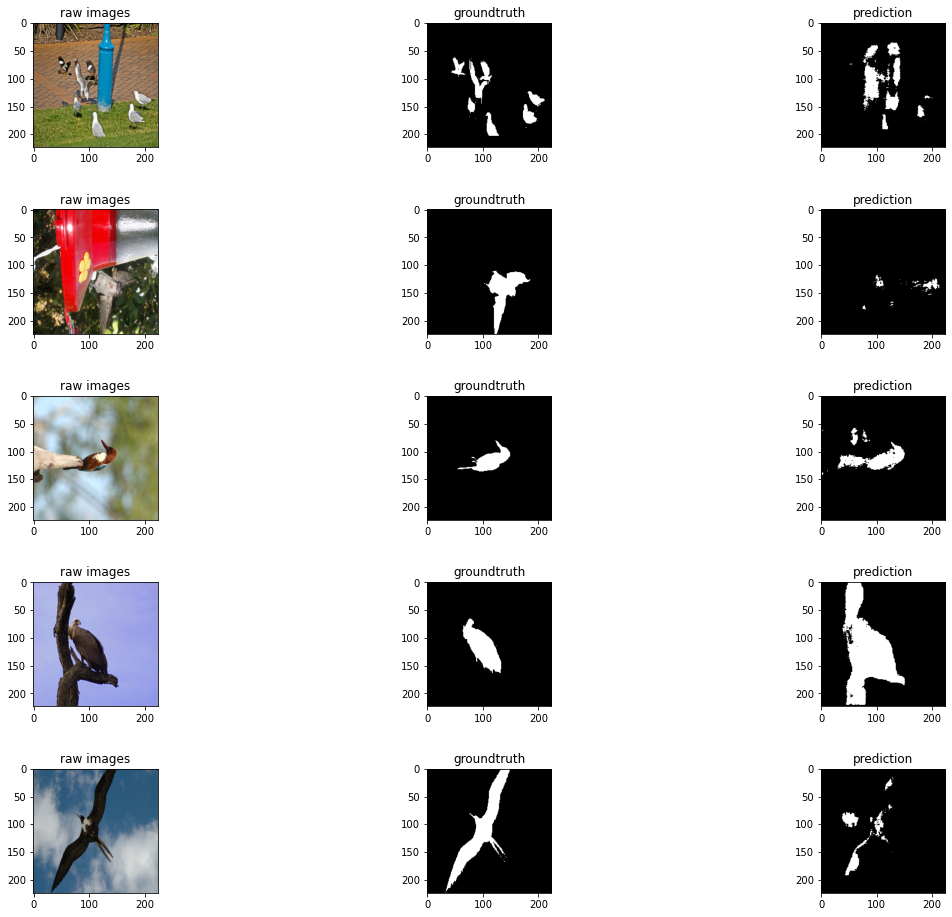

In [27]:
plot_batch_mask(imgs, groundtruth, prediction)

In [ ]:
experiment_number = config.experiment.number
experiment_description = config.experiment.description
experiment_root_path = os.path.join("leo_segmentation", "data", "models", f"experiment_{experiment_number}")
cached_files = os.listdir(experiment_root_path)
cached_files

In [ ]:
filename = cached_files[4]
val_ious = pd.read_pickle(os.path.join(experiment_root_path, filename)).T
print(f"filename: {filename}")
filtered_scores = []
for _class, _df in val_ious.iterrows():
    if _class == "episode":
        continue
    temp = [i for i in _df if not np.isnan(i)]
    class_sampling_frequency = len(temp)
    mean_of_all_ious_per_class = np.mean(temp)
    filtered_scores.append((_class, mean_of_all_ious_per_class, class_sampling_frequency))
filtered_val_ious = pd.DataFrame(filtered_scores, columns=["classes", "mean_val_ious", "class_sampling_frequency"])
filtered_val_ious = filtered_val_ious.sort_values(by="mean_val_ious", ascending=False)
filtered_val_ious[filtered_val_ious.mean_val_ious > 0.7].count()
filtered_val_ious

In [ ]:
os.listdir("leo_segmentation/data/fss1000/images")[600:800]

In [ ]:
filtered_val_ious.class_sampling_frequency.max()

In [ ]:
train_ious = pd.read_pickle(os.path.join(experiment_root_path, cached_files[2])).T
filtered_scores = []
for _class, _df in train_ious.iterrows():
    if _class == "episode":
        continue
    temp = [i for i in _df if not np.isnan(i)]
    class_sampling_frequency = len(temp)
    mean_of_all_ious_per_class = np.mean(temp)
    filtered_scores.append((_class, mean_of_all_ious_per_class, class_sampling_frequency))
filtered_train_ious = pd.DataFrame(filtered_scores, columns=["classes", "mean_train_ious", "class_sampling_frequency"])
filtered_train_ious = filtered_train_ious.sort_values(by="mean_train_ious", ascending=False)

In [ ]:
#classes in meta-train and meta-val are unique if their intersection is zero
set(filtered_train_ious.classes.unique()).intersection(set(filtered_val_ious.classes.unique()))

In [ ]:
meta_val_loss = pd.read_pickle(os.path.join(experiment_root_path, cached_files[5]))
meta_train_loss = pd.read_pickle(os.path.join(experiment_root_path, cached_files[3]))
num_data_points = meta_val_loss.shape[0]

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.title("meta_losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(np.arange(num_data_points), meta_val_loss.total_val_loss, label="meta_val_loss")
plt.plot(np.arange(num_data_points), meta_train_loss.total_val_loss, label="meta_train_loss")
plt.legend()

In [ ]:
results_path = "leo_segmentation/data/models/experiment_15"
cached_files = os.listdir(results_path)
cached_files = {i:k for i,k in enumerate(cached_files)}
cached_files

In [ ]:
result_df = pd.read_pickle(os.path.join(results_path, cached_files[4]))
fig = plt.figure(figsize=(10, 7))
for i in range(5):
    plt.plot(result_df.iloc[:,i], label=result_df.columns[i])
plt.legend()

In [ ]:
train_results_df = pd.read_pickle(os.path.join(results_path, cached_files[2]))
train_results_df.fillna(0.0).max().sort_values(ascending=False)

In [ ]:
counts_per_col={}
for i in range(len(train_results_df.columns)):
    if train_results_df.columns[i] == "episode":
        continue
    temp = train_results_df.iloc[:,i]
    temp = temp.dropna()
    counts_per_col[train_results_df.columns[i]] = len(temp)
pd.Series(counts_per_col).sort_values(ascending=False)

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(pd.read_pickle(os.path.join(results_path,
            cached_files[3]))["total_val_loss"], label="train")
plt.plot(pd.read_pickle(os.path.join(results_path,
            cached_files[5]))["total_val_loss"], label="val")
plt.legend()